In [2]:
!pip install numpy tensorflow_datasets
import fnmatch
import os
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
data, info = tfds.load('malaria', split = 'train', shuffle_files = True, as_supervised = False, with_info = True)

NameError: name 'tfds' is not defined

# Examples of labeled images

2022-03-13 20:46:00.143671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


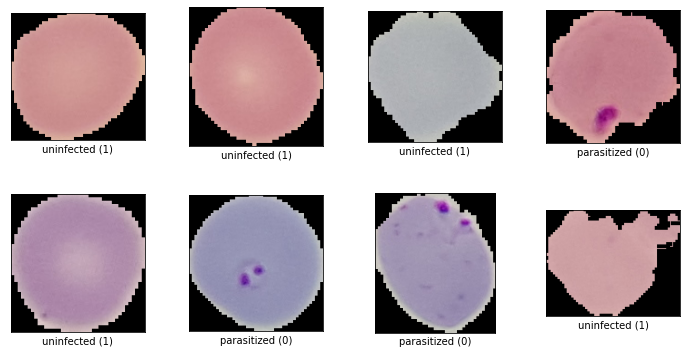

In [3]:
#Examples of data.
fig = tfds.show_examples(data, info, rows = 2, cols = 4)

# Data Loading and Formatting

## Reshape image resolution to 24 x 24, with RGB data.

In [140]:
directory = 'tensorflow_datasets/downloads/extracted/rat/cell_images'
cats = ['Parasitized', 'Uninfected']
img_size = 24
data = []

for cat in cats:
    path = os.path.join(directory, cat)
    label = cats.index(cat)
    for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path,img)
                                     )
                new_arr = cv2.resize(img_arr, (img_size, img_size))
        #plt.imshow(img_arr, cmap = 'gray')
                data.append([new_arr, label])
            except Exception as e:
                pass



## Shuffle the dataset

In [168]:
import random
random.shuffle(data)

## Create arrays X and y which hold the data and and corresponding label for each image  (0 = Parasitic, 1 = Uninfected) . The labels will be used later to assess model performance

In [169]:
X = []
y = []
for features, label in data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3)
#X = X.reshape(-1,img_size * img_size

X = X.reshape(-1,img_size * img_size * 3)
X = X.T

## Here is an example of a resized image.

<function matplotlib.pyplot.show(close=None, block=None)>

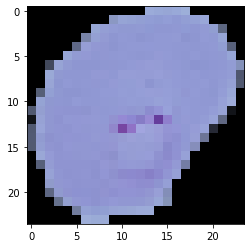

In [142]:

example = X[:,1].reshape(24,24,3)
plt.imshow(example)
plt.show

# PCA Implementation

## The sample mean of the resized images is shown below.

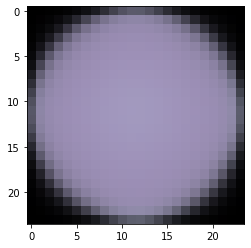

In [143]:

#Calculate Mean Cell Image
X.shape
mean_cell = np.mean(X, axis = 1)
mean_cell = mean_cell[:,None]
plt.imshow(mean_cell.reshape([img_size,img_size,3])/255)
mean_cell.shape

A = X - mean_cell

In [144]:
A.shape

(1728, 27558)

## Calculate zero-mean image

In [145]:
covmatrix = A @ A.T

In [146]:
eigvals, V = np.linalg.eig(covmatrix)

## Scree Plots of PCA

Text(0.5, 1.0, 'Scree Plot')

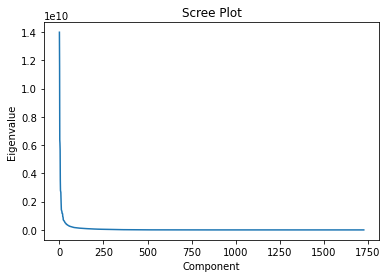

In [147]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort
# Tim Marks 2002
vsort, dsort = eigsort(V, eigvals)
plt.plot(range(len(dsort)), dsort.diagonal(),'-')
plt.ylabel('Eigenvalue')
plt.xlabel('Component')
plt.title('Scree Plot')

Text(0, 0.5, 'Proportion of Variance Explained')

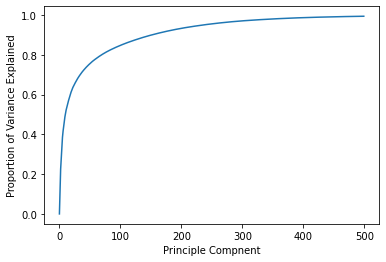

In [148]:
expl = []
for i in range(500):
    expl.append(np.sum(dsort[0:i])/ np.sum(dsort))
expl
plt.plot(range(500), expl, '-')
plt.xlabel('Principle Compnent')
plt.ylabel('Proportion of Variance Explained')

## 90.654% of the variance can be explained by 160 principal components

In [189]:
components = vsort.T @ A
components = components[:160,:]
components.shape

(160, 27558)

# K-means Implementation, K = 2

In [190]:
def calcSqDistances(X, Kmus):
    g,h = X.shape[0], Kmus.shape[0]
    sqDist = np.zeros((g,h),dtype =np.float32)
    
    for i in range(g):
        for o in range(h):
                sqDist[i,o] = np.linalg.norm(X[i] - Kmus[o])
    return sqDist
def determineRnk(sqDmat):
    Rnk = np.zeros((sqDmat.shape))
    for i in range(len(sqDmat)):
        c = np.argmin(sqDmat[i])
        Rnk[i,c] = 1
    return Rnk
def recalcMus(X, Rnk):
    k = Rnk.shape[1]
    d = X.shape[1]
    Kmus_new = np.zeros((k,d))
    
    return np.divide(X.T @ Rnk, np.sum(Rnk, axis = 0)).T
    return Kmus_new
import time

def runKMeans(K, X):
        
    N, D = X.shape

    rand_inds = np.random.permutation(N)
    Kmus_old = X[rand_inds[0:K],:]
    Kmus_old.shape
  
    maxiters = 10

    for iter in range(maxiters):

        sqDmat = calcSqDistances(X, Kmus_old)
  
        Rnk = determineRnk(sqDmat)      
        
        Kmus_new = recalcMus(X, Rnk)
        Kmus_old = Kmus_new
          
    return Kmus_old

In [201]:
Kmus = runKMeans(2, components.T)
ypred = np.zeros(27558)
for i in range(27558):
    if np.linalg.norm(components[:,i]-Kmus[0]) < np.linalg.norm(components[:,i]-Kmus[1]):
        ypred[i] = 1
    else:
        continue

In [202]:
np.mean((np.array(y) - ypred)**2)

0.5018143551781696

1